In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,roc_auc_score, balanced_accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from mrmr import mrmr_classif
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.inspection import plot_partial_dependence

import shap
from time import time


In [2]:
data = pd.read_csv("heart_2020_cleaned.csv")


In [3]:
data.head()


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


BMI : Body Mass Index (BMI)
    
DiffWalking: Serious difficulty walking or climbing stairs

In [4]:
data.isnull().sum()


HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

No null values

In [5]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [6]:
# Discovering the unique values of AgeCategory so we can examine some replacements.
data['AgeCategory'].unique()


array(['55-59', '80 or older', '65-69', '75-79', '40-44', '70-74',
       '60-64', '50-54', '45-49', '18-24', '35-39', '30-34', '25-29'],
      dtype=object)

In [7]:
data.GenHealth.unique()


array(['Very good', 'Fair', 'Good', 'Poor', 'Excellent'], dtype=object)

# Data Cleaning

In [8]:
# Replacing AgeCategory values with representative float values
encode_AgeCategory = {'55-59':57, '80 or older':80, '65-69':67,
                      '75-79':77,'40-44':42,'70-74':72,'60-64':62,
                      '50-54':52,'45-49':47,'18-24':21,'35-39':37,
                      '30-34':32,'25-29':27}
data['AgeCategory'] = data['AgeCategory'].apply(lambda x: encode_AgeCategory[x])
data['AgeCategory'] = data['AgeCategory'].astype('float')


In [9]:
# Replacing 'Yes' and 'No' values with '1' and '0'
data.replace(to_replace=['Yes','No'],value=[1,0], inplace= True)
data.replace(to_replace=['Male','Female'],value=[1,0], inplace= True)


In [10]:
# Replacing some different values
data.replace(to_replace=['Yes (during pregnancy)','No, borderline diabetes'],value=[1,0], inplace= True)


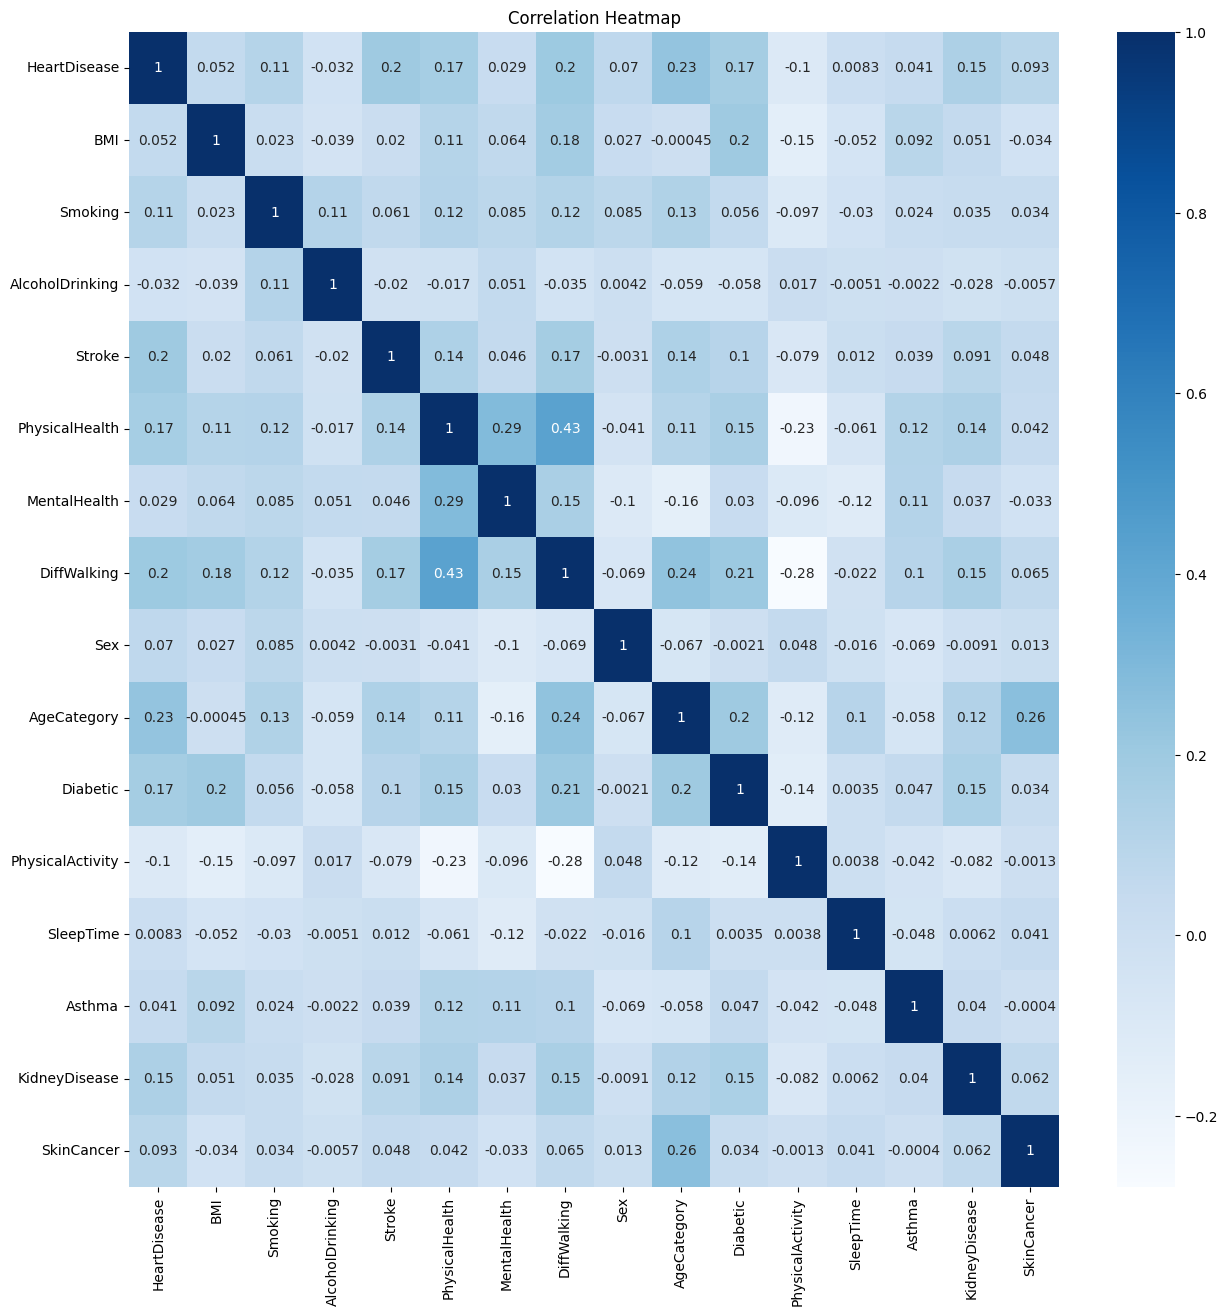

In [11]:
# Correlation Heatmap
plt.figure(figsize=(15, 15))
plt.title("Correlation Heatmap")
heatmap = sns.heatmap(data.corr(), annot=True, cmap="Blues")


No high correlatons between features or between features and target (HeartDisease).

In [12]:
data.head()


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,0,57.0,White,1,1,Very good,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,0,80.0,White,0,1,Very good,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,1,67.0,White,1,1,Fair,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,0,77.0,White,0,0,Good,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,0,42.0,White,0,1,Very good,8.0,0,0,0


In [13]:
data['Race'].unique()


array(['White', 'Black', 'Asian', 'American Indian/Alaskan Native',
       'Other', 'Hispanic'], dtype=object)

In [14]:
# Get dummies to include object values into our model
data = pd.get_dummies(data, columns=['Race', 'GenHealth'])


In [15]:
data['HeartDisease'].value_counts()


0    292422
1     27373
Name: HeartDisease, dtype: int64

### We have a 320k row dataset. Let's take a random sample.


In [16]:
df = data.sample(n = 100000)


In [17]:
df.shape


(100000, 27)

##### The new dataset seems to contain a big ammount of rows (100k) comparatively with the small ammount of features (27).
##### That is a good choice for our model.

In [18]:
# target's distribution
df['HeartDisease'].value_counts()


0    91301
1     8699
Name: HeartDisease, dtype: int64

It seems like we deal with an impalanced target, but because of the big ammount of data we should choose not to balance them to avoid missleading issues.

##### Health care field needs to depend on an accurate dataset with real data.

<AxesSubplot: xlabel='HeartDisease', ylabel='count'>

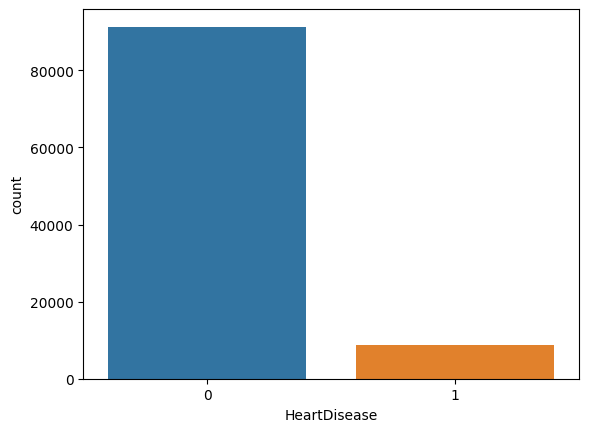

In [19]:
# Visualization of the target's distribution.
sns.countplot(x = df['HeartDisease'])


### Let's examine the outliers.

<AxesSubplot: >

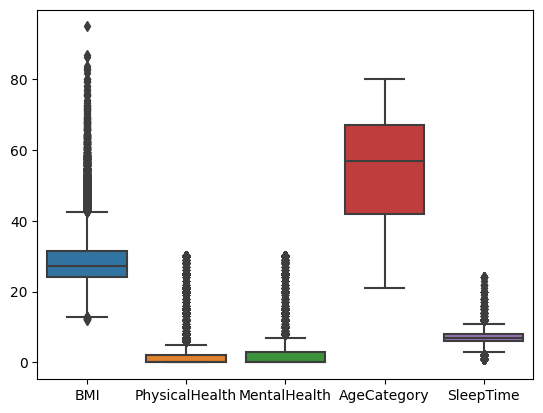

In [20]:
sns.boxplot(df[['BMI','PhysicalHealth', 'MentalHealth','AgeCategory', 'SleepTime']])


We can see than there are some outliers which could misslead our model. We choose to drop the BMI outliers (over 3 std).

In [21]:
df = df[np.abs(df['BMI']-df['BMI'].mean()) <= (3*df['BMI'].std())]


# Testing various estimators

In [52]:
X = df.drop('HeartDisease', axis= 1)
y = df['HeartDisease'].values


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=5)
# 20% test set
# 80% training set


In [54]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
# Scaling for better performance
# Scaling the data into [-1,1]


In [55]:

estimators = [
              GradientBoostingClassifier(),
              AdaBoostClassifier(),
              xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
              RandomForestClassifier(),
              KNeighborsClassifier(),
              GaussianNB(),
              LogisticRegression()
              ]


In [56]:
metrics = {}
for estimator in estimators:
    tic = time()
    estimator.fit(X_train_sc, y_train)
    predictions = estimator.predict(X_test_sc)
    toc = time()
    metrics[str(estimator).split('(')[0]] = {
        'balanced accuracy':round(balanced_accuracy_score(y_test, predictions),2),
        'macro f1':round(f1_score(y_test, predictions, average='macro'),2),
        'recall score': round(recall_score(y_test, predictions),2),
        'precision score': round(precision_score(y_test, predictions),2),
        'roc_auc_score': round(roc_auc_score(y_test, predictions),2),
        'fit time':round(toc - tic,2)
        }
    print (str(estimator).split('(')[0])
    print (classification_report(predictions, y_test))
    print (confusion_matrix(y_test, predictions))
    print ()
    

GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.99      0.92      0.96     19479
           1       0.09      0.58      0.16       271

    accuracy                           0.92     19750
   macro avg       0.54      0.75      0.56     19750
weighted avg       0.98      0.92      0.94     19750

[[17923   115]
 [ 1556   156]]

AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     19358
           1       0.12      0.53      0.20       392

    accuracy                           0.91     19750
   macro avg       0.56      0.73      0.58     19750
weighted avg       0.97      0.91      0.94     19750

[[17855   183]
 [ 1503   209]]

XGBClassifier
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     19391
           1       0.10      0.47      0.16       359

    accuracy                           0.91     19750
   m

In [57]:
# Performance Metrics

metrics = pd.DataFrame(metrics)
metrics


,GradientBoostingClassifier,AdaBoostClassifier,XGBClassifier,RandomForestClassifier,KNeighborsClassifier,GaussianNB,LogisticRegression
balanced accuracy,0.54,0.56,0.54,0.54,0.55,0.69,0.55
macro f1,0.56,0.58,0.56,0.55,0.57,0.62,0.57
recall score,0.09,0.12,0.10,0.10,0.13,0.53,0.11
precision score,0.58,0.53,0.47,0.35,0.36,0.26,0.55
roc_auc_score,0.54,0.56,0.54,0.54,0.55,0.69,0.55
fit time,9.34,2.57,7.10,8.51,37.93,0.07,0.21


performing with default parameters:

- Better performing algorythm --> GaussianNB (recall score =0.53, fit time = 0.06 sec)

- Slowest performing algorythm --> KNeighborsClassifier (fit time = 35.67 sec)

- Comparing boosting algorythms, AdaBoostClassifier is the best performing model as it has the higher recall score (0.12) and the lower fit time (2.81 sec)

We prefer to use Boosting algorythms because they can perform better on imbalanced datasets.

### What metrics should we examine?

Accuracy measures the percentage of the correctly classified instances, namely, how many instances that classified 
as 1 ( = The patient has heart disease) (or 0) are indeed classified as 1.
But when the dataset is imbalanced, accuracy may be missleading, bc accuracy does not measure the misclassification error (False Positives and False Negatives)

On the other hand, Recall is a useful measure for our case. 
Recall measures the rate of correctly classified against the total number of results classified as correct.
##### In our case, Recall measures how many of the patients we predicted they have heart disease, have in fact heart disease?
##### In other words, we can see if there are patients that predicted to be healthy but they are not!!!

### Which of the models above has the best performance?

That's a quastion we are not capable to answer right now.
The metrics above are a result of default - parametered models.
Let's examine several parameters to every model to optimize the results.



In [67]:
metrics.values


array([[ 0.54,  0.56,  0.54,  0.54,  0.55,  0.69,  0.55],
       [ 0.56,  0.58,  0.56,  0.55,  0.57,  0.62,  0.57],
       [ 0.09,  0.12,  0.1 ,  0.1 ,  0.13,  0.53,  0.11],
       [ 0.58,  0.53,  0.47,  0.35,  0.36,  0.26,  0.55],
       [ 0.54,  0.56,  0.54,  0.54,  0.55,  0.69,  0.55],
       [ 9.34,  2.57,  7.1 ,  8.51, 37.93,  0.07,  0.21]])

In [68]:
metrics.index


Index(['balanced accuracy', 'macro f1', 'recall score', 'precision score',
       'roc_auc_score', 'fit time'],
      dtype='object')

<Figure size 2000x1000 with 0 Axes>

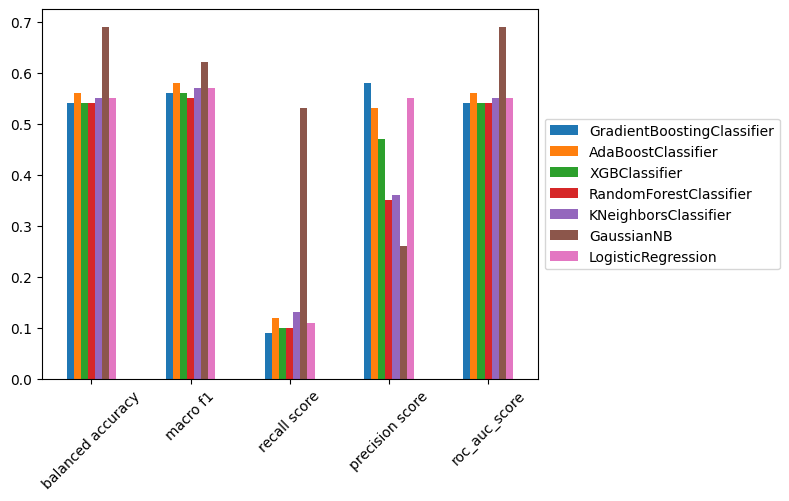

In [84]:
# Visualization of results
plt.figure(figsize = (20,10))
axes = metrics.iloc[:-1].plot.bar()
axes.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))  
plt.xticks(rotation = 45)
None




----------------

# Feature Selection

Before starting to optimize our models, it is a good idea to examine which features are more important.
##### In this way we manage to reduce the complexity, maintaning a good performance.

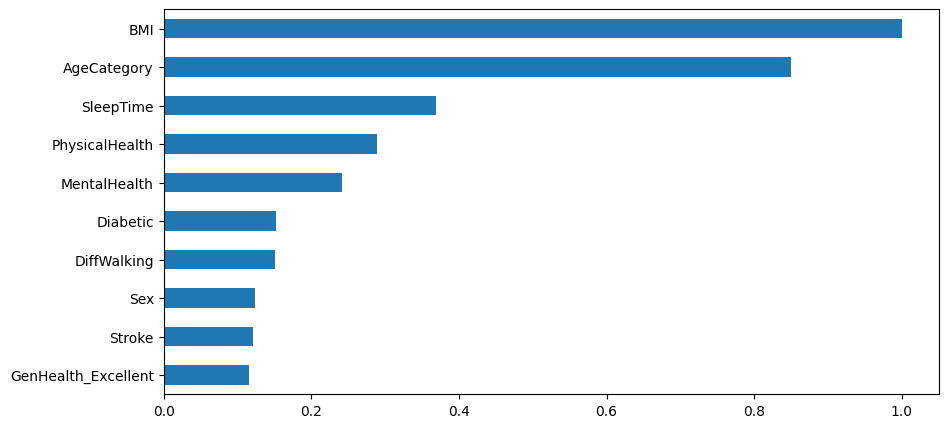

In [33]:
# Getting top 10 features (feature importances for Random Forest Classifier)


X = df.drop('HeartDisease', axis= 1)
y = df['HeartDisease'].values

# train - test split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=5)


classifier = RandomForestClassifier(class_weight='balanced')


classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

importance = pd.Series(classifier.feature_importances_, index=list(X))
importance = importance/importance.max()
importance = importance.sort_values(ascending=False).head(10)
importance.sort_values().plot.barh(figsize=(10,5))
plt.show()


In [34]:
print (f"Most important features on Random Forest Classifier are: {list(importance.index)}")


Most important features on Random Forest Classifier are: ['BMI', 'AgeCategory', 'SleepTime', 'PhysicalHealth', 'MentalHealth', 'Diabetic', 'DiffWalking', 'Sex', 'Stroke', 'GenHealth_Excellent']


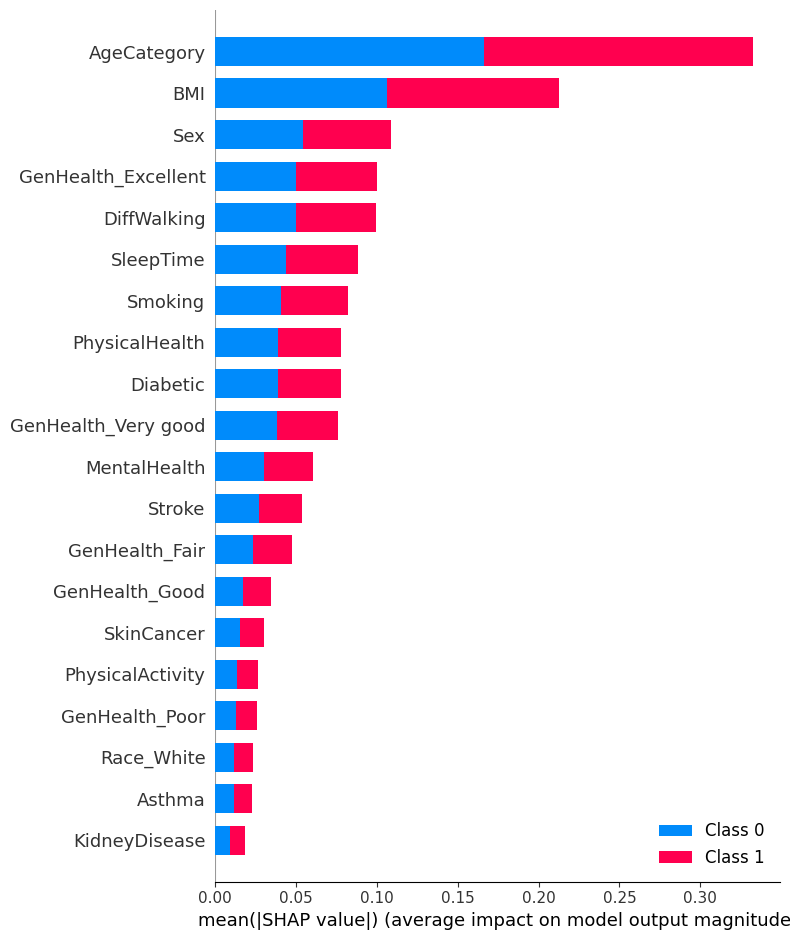

In [22]:
# SHAP
# We can just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs)
X = df.drop('HeartDisease', axis= 1)
y = df['HeartDisease'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=5)

classifier = RandomForestClassifier(class_weight='balanced')


classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

shap_values = shap.TreeExplainer(classifier).shap_values(X_train, approximate=True)

shap.summary_plot(shap_values, X_train, plot_type="bar",feature_names=X.columns)


# The idea behind SHAP feature importance is simple: Features with large absolute Shapley values are important.

100%|===================| 157964/157968 [463:43<00:00]         

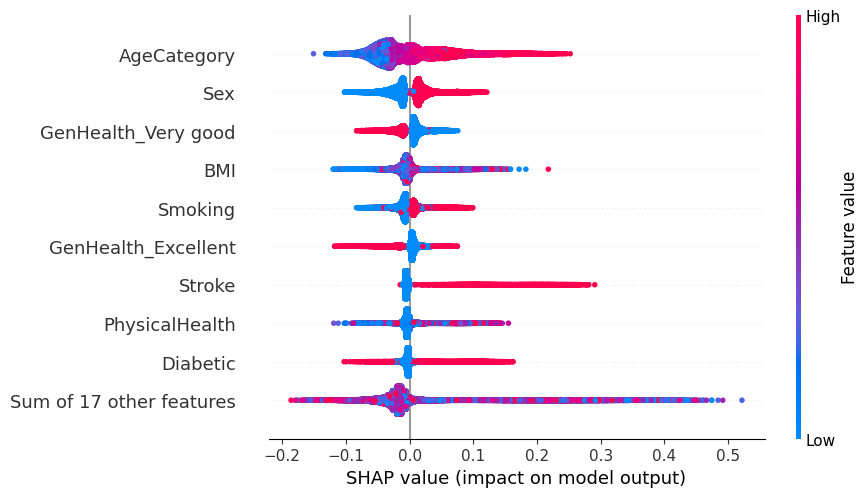

In [23]:
explainer = shap.TreeExplainer(classifier, X_train, feature_names=X.columns)
shap_values_rfc = explainer(X_train, check_additivity=False)
shap_values_rfc_pos = shap_values_rfc[..., 1]
shap.plots.beeswarm(shap_values_rfc_pos, max_display=10)

# The summary plot combines feature importance with feature effects. 
# Each point on the summary plot is a Shapley value for a feature and an instance.
# The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. 
# The color represents the value of the feature from low to high. Overlapping points are jittered in
# y-axis direction, so we get a sense of the distribution of the Shapley values per feature.
# The features are ordered according to their importance.


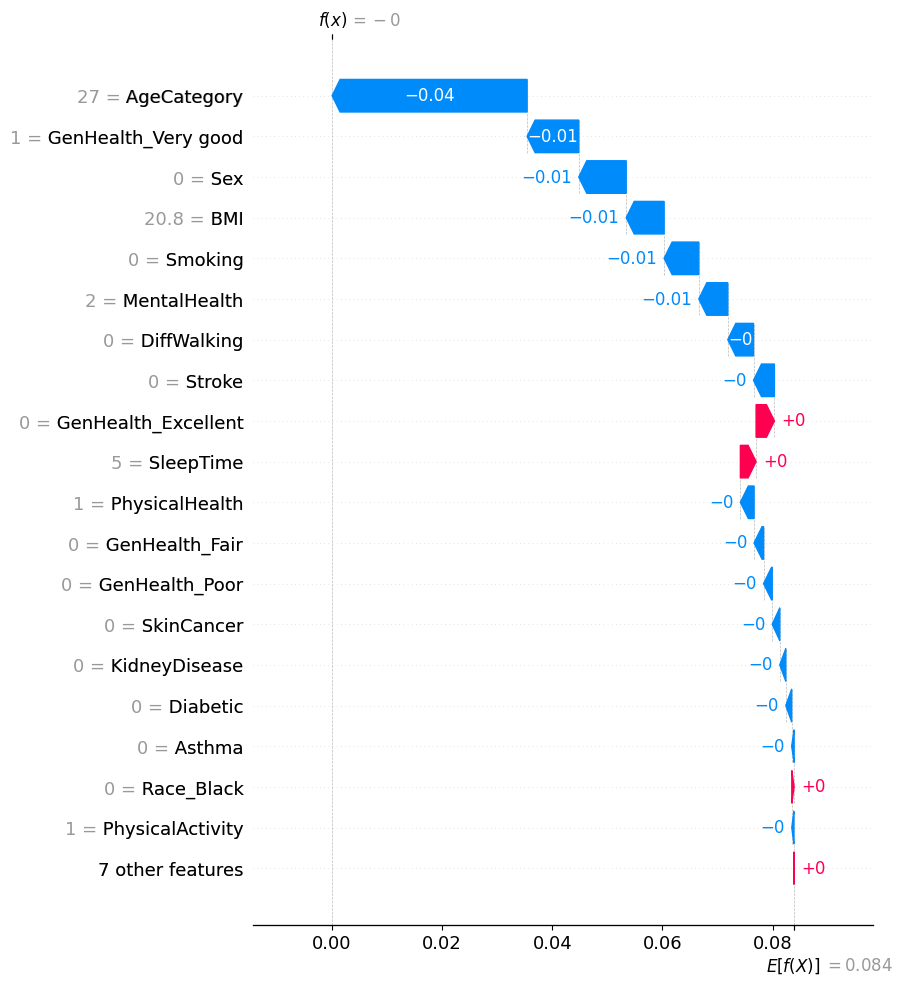

'\nIn the waterfall above, the x-axis has the values of the target (dependent) variable which \nis the house price. x is the chosen observation, f(x) is the predicted value of the model, \ngiven input x and E[f(x)] is the expected value of the target variable, or in other words,\nthe mean of all predictions (mean(model.predict(X))).\n\nThe SHAP value for each feature in this observation is given by the length of the bar. \nIn the example above, Longitude has a SHAP value of -0.48, Latitude has a SHAP of +0.25 and so on. \nThe sum of all SHAP values will be equal to E[f(x)] — f(x).\n\nThe absolute SHAP value shows us how much a single feature affected the prediction\n\nNote that these SHAP values are valid for this observation only. With other data points the SHAP values will change.\n'

In [24]:
shap.plots.waterfall(shap_values_rfc_pos[0], max_display=20)

"""
In the waterfall above, the x-axis has the values of the target (dependent) variable which 
is the house price. x is the chosen observation, f(x) is the predicted value of the model, 
given input x and E[f(x)] is the expected value of the target variable, or in other words,
the mean of all predictions (mean(model.predict(X))).

The SHAP value for each feature in this observation is given by the length of the bar. 
In the example above, Longitude has a SHAP value of -0.48, Latitude has a SHAP of +0.25 and so on. 
The sum of all SHAP values will be equal to E[f(x)] — f(x).

The absolute SHAP value shows us how much a single feature affected the prediction

Note that these SHAP values are valid for this observation only. With other data points the SHAP values will change.
"""


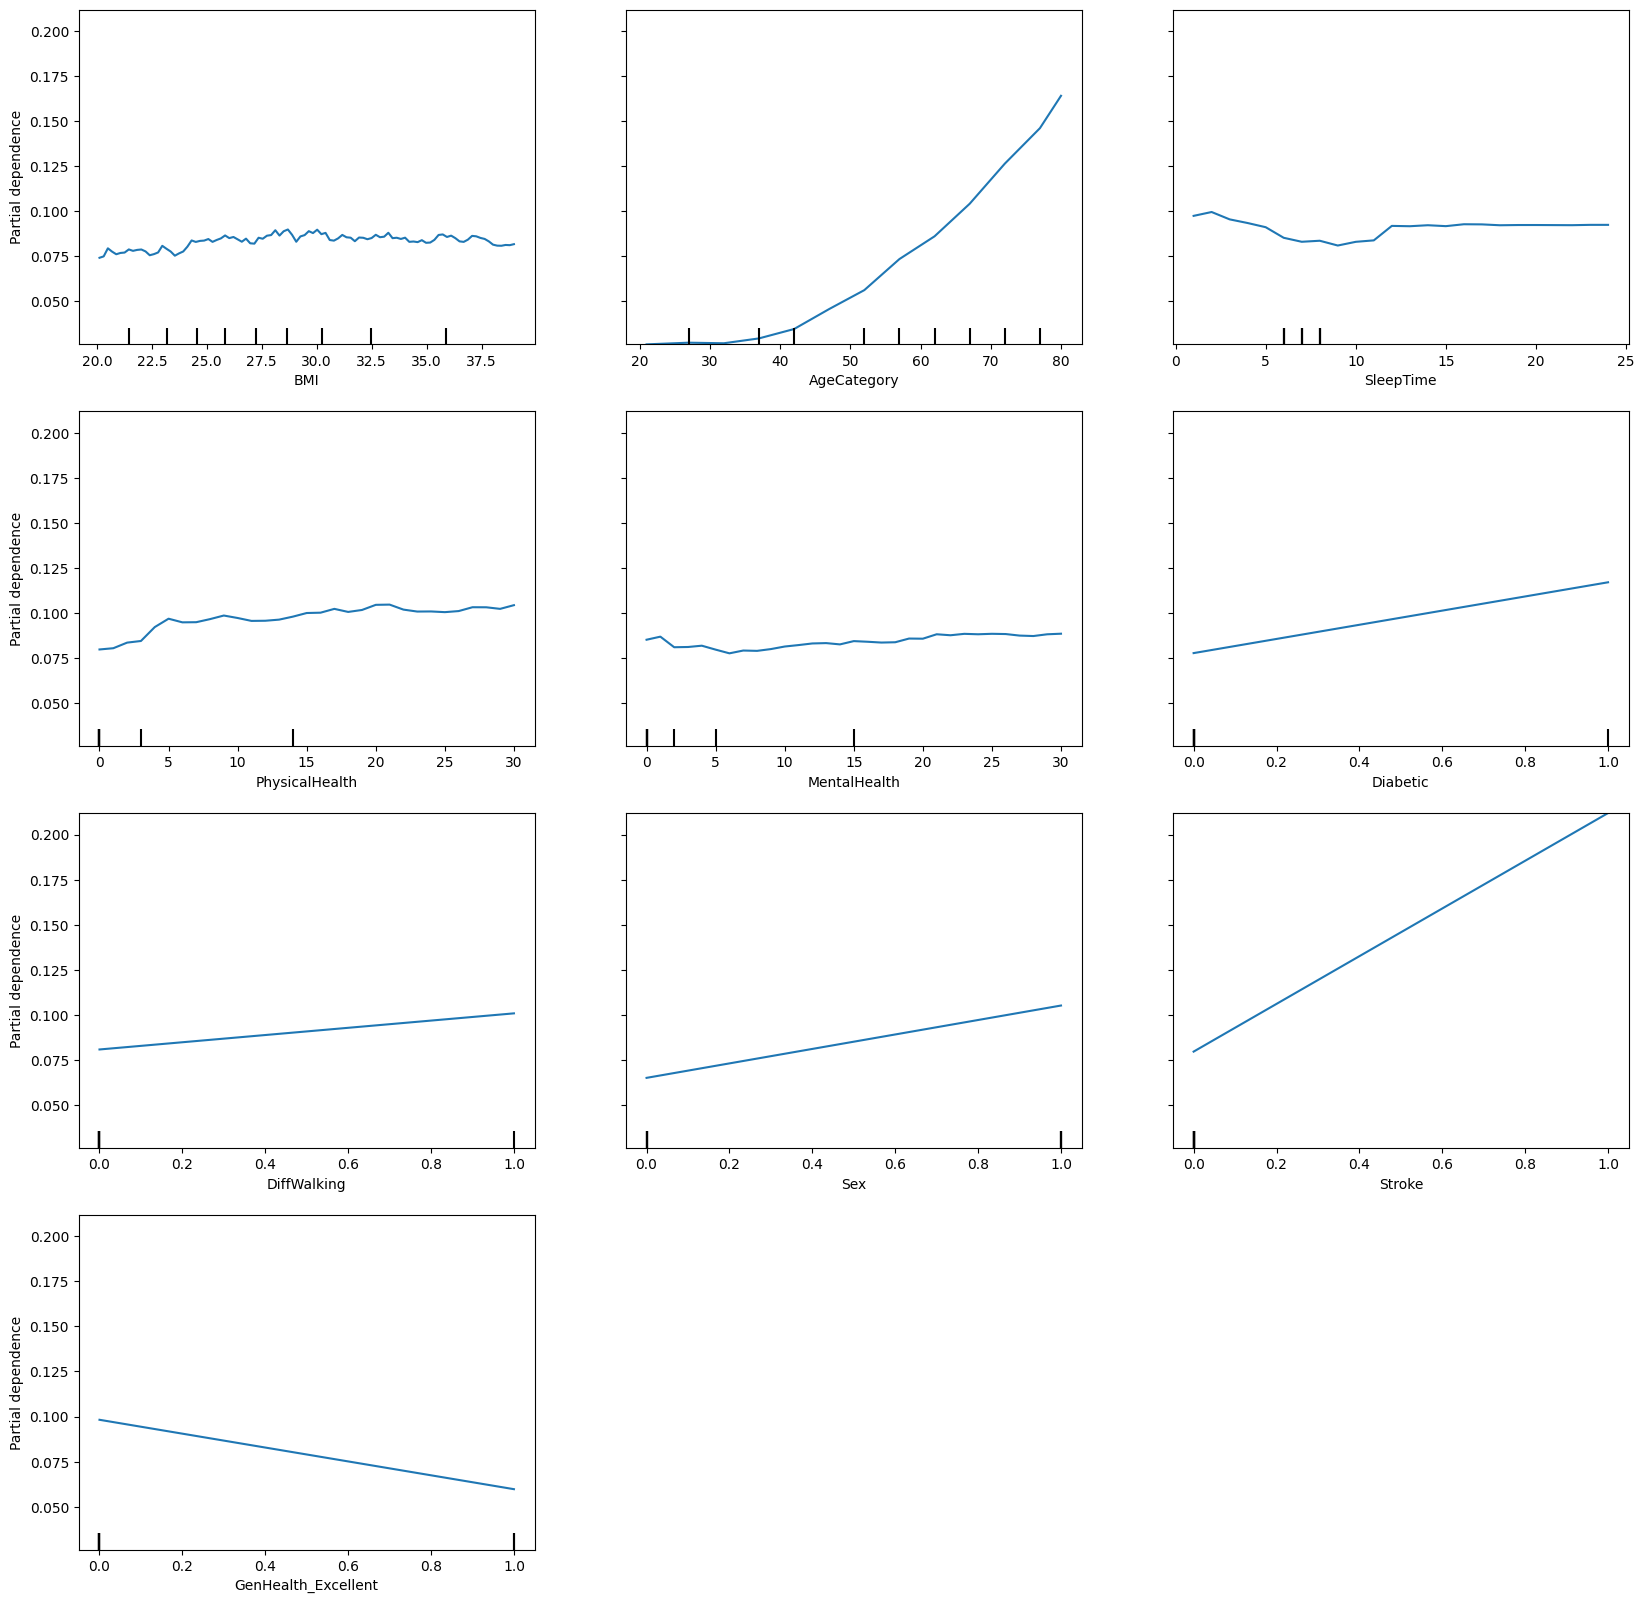

In [36]:
# plot_partial_dependence (RandomForestClassifier)

X = df.drop('HeartDisease', axis= 1)
y = df['HeartDisease'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=5)

classifier = RandomForestClassifier(class_weight='balanced')
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)



fig, ax = plt.subplots(figsize=(20, 20))
plot_partial_dependence(classifier, X_train, importance.index, ax=ax)
plt.show()


### Select k Best

In [37]:
# Chi2
bestfeatures = SelectKBest(score_func = chi2, k=20)
fit = bestfeatures.fit(X,y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)
feature_scores = pd.concat([df_columns,df_scores], axis =1)
feature_scores.columns = ['feature', 'score']
top_10_chi = feature_scores.nlargest(10,'score')
print(top_10_chi)


                feature         score
4        PhysicalHealth  54776.511377
8           AgeCategory  30743.519988
3                Stroke   3589.523281
6           DiffWalking   3428.810673
9              Diabetic   2753.204862
24       GenHealth_Poor   2662.932969
22       GenHealth_Fair   2175.380899
13        KidneyDisease   2029.847238
5          MentalHealth   1239.019065
21  GenHealth_Excellent   1113.794029


In [38]:
top_10_chi_list = top_10_chi['feature']
top_10_chi_list.values


array(['PhysicalHealth', 'AgeCategory', 'Stroke', 'DiffWalking',
       'Diabetic', 'GenHealth_Poor', 'GenHealth_Fair', 'KidneyDisease',
       'MentalHealth', 'GenHealth_Excellent'], dtype=object)

# MRMR

In [39]:
# MRMR
selected_features_MRMR = mrmr_classif(X=X_train, y=y_train, K=10)
selected_features_MRMR


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.52it/s]


['AgeCategory',
 'GenHealth_Poor',
 'Stroke',
 'GenHealth_Fair',
 'Sex',
 'Diabetic',
 'KidneyDisease',
 'DiffWalking',
 'Smoking',
 'PhysicalHealth']

# Testing various estimators with selected features (MRMR) 
# Hyperparameter tuning 

In [40]:
# Hyperparameter tuning (Random Forest Classifier)

X = df[selected_features_MRMR]
y = df['HeartDisease'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=5)

classifier = RandomForestClassifier()

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('feat_generation', PolynomialFeatures(interaction_only=True, include_bias=False)),
    ('classifier', classifier)
])


# Define the hyperparameters to be optimized
param_grid = {
    'classifier__max_depth': [1.5, 2, 2.5, 10],   # The maximum depth of the tree. 
    'classifier__n_estimators': [80,94, 100,105], # The number of trees in the forest.
    'classifier__criterion' :["gini"],            # The function to measure the quality of a split
    'classifier__class_weight': ["balanced"]      # Weights associated with classes 
    
}

# Perform grid search to find the optimal hyperparameters
grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring='recall')
grid_search.fit(X_train, y_train)
preds = grid_search.predict(X_test)


# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Evaluate the performance of the optimized classifier on the test set
test_recall = grid_search.score(X_test, y_test)
print("Test recall: ", test_recall)
print (confusion_matrix(y_test, preds))


Best hyperparameters:  {'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_depth': 2, 'classifier__n_estimators': 80}
Test recall:  0.8358644859813084
[[11287  6751]
 [  281  1431]]


In [41]:
# Hyperparameter tuning (Gradient Boosting Classifier)

X = df[selected_features_MRMR]
y = df['HeartDisease'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=5)

classifier = GradientBoostingClassifier()

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('feat_generation', PolynomialFeatures(interaction_only=True, include_bias=False)),
    ('classifier', classifier)
])


# Define the hyperparameters to be optimized
param_grid = {
    "classifier__learning_rate": [0.01, 0.1,0.17, 0.2], # Learning rate shrinks the contribution of each tree
    "classifier__max_depth":[1,2,3],                     # The maximum depth limits the number of nodes in the tree.
    "classifier__max_features":["sqrt"],                 # The number of features to consider when looking for the best split
    "classifier__criterion": [ "squared_error"],         # The function to measure the quality of a split
    "classifier__n_estimators":[10, 50, 80]             # The number of boosting stages to perform.
}

# Perform grid search to find the optimal hyperparameters
grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring='recall')
grid_search.fit(X_train, y_train)
preds = grid_search.predict(X_test)


# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Evaluate the performance of the optimized classifier on the test set
test_recall = grid_search.score(X_test, y_test)
print("Test recall: ", test_recall)
print (confusion_matrix(y_test, preds))

Best hyperparameters:  {'classifier__criterion': 'squared_error', 'classifier__learning_rate': 0.2, 'classifier__max_depth': 1, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 80}
Test recall:  0.07126168224299065
[[17923   115]
 [ 1590   122]]


In [42]:
X = df[selected_features_MRMR]
y = df['HeartDisease'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=5)

classifier = GradientBoostingClassifier(n_estimators= 50, criterion="squared_error", max_features="sqrt", learning_rate=0.17, max_depth = 3, min_samples_split=0.5, min_samples_leaf=10, subsample =0.9)
classifier.fit(X_train, y_train)
preds = classifier.predict(X_test)

test_recall = classifier.score(X_test, y_test)
print("Test recall: ", test_recall)
print (confusion_matrix(y_test, preds))

Test recall:  0.9150379746835443
[[17972    66]
 [ 1612   100]]


In [44]:
# Hyperparameter tuning (XGBClassifier)

X = df[selected_features_MRMR]
y = df['HeartDisease'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=5)

classifier = xgb.XGBClassifier()

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('feat_generation', PolynomialFeatures(interaction_only=True, include_bias=False)),
    ('classifier', classifier)
])


# Define the hyperparameters to be optimized
param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__learning_rate': [0.01,0.05,0.1],
    'classifier__booster': ['gbtree', 'gblinear'],
}

# Perform grid search to find the optimal hyperparameters
grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring='recall')
grid_search.fit(X_train, y_train)
preds = grid_search.predict(X_test)


# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Evaluate the performance of the optimized classifier on the test set
test_recall = grid_search.score(X_test, y_test)
print("Test recall: ", test_recall)
print (confusion_matrix(y_test, preds))


Best hyperparameters:  {'classifier__booster': 'gbtree', 'classifier__learning_rate': 0.1, 'classifier__n_estimators': 500}
Test recall:  0.09228971962616822
[[17840   198]
 [ 1554   158]]


In [51]:
# Hyperparameter tuning (AdaBoostClassifier())

X = df[selected_features_MRMR]
y = df['HeartDisease'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=5)

classifier = AdaBoostClassifier()

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('feat_generation', PolynomialFeatures(interaction_only=True, include_bias=False)),
    ('classifier', classifier)
])


# Define the hyperparameters to be optimized

param_grid = {'classifier__n_estimators': [ 1, 2, 10, 15],
              'classifier__learning_rate':[ 1.5,1.75,2]
             }

# Perform grid search to find the optimal hyperparameters
grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring='recall')
grid_search.fit(X_train, y_train)
preds = grid_search.predict(X_test)


# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Evaluate the performance of the optimized classifier on the test set
test_recall = grid_search.score(X_test, y_test)
print("Test recall: ", test_recall)
print (confusion_matrix(y_test, preds))


Best hyperparameters:  {'classifier__learning_rate': 2, 'classifier__n_estimators': 2}
Test recall:  0.3878504672897196
[[16360  1678]
 [ 1048   664]]


# Which is the best performing model?

### Random Forest Classifier:

High recall score (0.84)

- 11k predicted as positive to heart disease and are actual positive.

- 1,4k predicted as negative to heart disease and are actual negative.

- 6,8k predicted as positive to heart disease but are actual negative.

- Only 281 predicted as negative to heart disease but are actual positive. 



### Gradient Boosting Classifier:

Higher recall score (0.92)

- 18k predicted as positive to heart disease and are actual positive.

- 100 predicted as negative to heart disease and are actual negative.

- 66 predicted as positive to heart disease but are actual negative.

- 1,6k predicted as negative to heart disease but are actual positive. 



### XGBClassifier:

Low recall score (0.09)

- 18k predicted as positive to heart disease and are actual positive.

- 158 predicted as negative to heart disease and are actual negative.

- 198 predicted as positive to heart disease but are actual negative.

- 1,5k predicted as negative to heart disease but are actual positive. 


### AdaBoostClassifier:

Medium recall score (0.39)

- 16k predicted as positive to heart disease and are actual positive.

- 664 predicted as negative to heart disease and are actual negative.

- 1,7k predicted as positive to heart disease but are actual negative.

- 1k predicted as negative to heart disease but are actual positive. 



# Conclusion


According to our results and the data we had to deal with, we decided to pay attention to the False Negative score.
The reason why FN is more valuable for data is because it is more important to predict wrong that a patient has heart disease, while he has not, than predicting wrong that a patient has not heart disease, while he has. 
So, Random Forest Classifier is the best performing model as FN score of the confusion matrix has the lower value (281 patients), while Recall score is in a high level (0.84).

